# **Urban Flood Risk Data Audit Process**

This notebook identifies missing, inconsistent, and outlier values to assess overall data integrity before explatory analysis, modelling and visualising. This is to represent the process I normally undertake to audit the data before embarking on any modelling, testing and so forth.


In [1]:
# mounting Google Drive for file extraction:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# importing the dataset (found it on kaggle):
df=pd.read_csv("/content/drive/MyDrive/urban_pluvial_flood_risk_dataset.csv")

# previewing:
display(df.head())
df.info()

,segment_id,city_name,admin_ward,latitude,longitude,catchment_id,elevation_m,dem_source,land_use,soil_group,drainage_density_km_per_km2,storm_drain_proximity_m,storm_drain_type,rainfall_source,historical_rainfall_intensity_mm_hr,return_period_years,risk_labels
0,SEG-00001,"Colombo, Sri Lanka",Borough East,6.920633,79.912600,CAT-136,NaN,Copernicus_EEA-10_v5,Institutional,NaN,4.27,160.5,CurbInlet,ERA5,39.4,50,monitor
1,SEG-00002,"Chennai, India",Ward D,13.076487,80.281774,CAT-049,-2.19,Copernicus_EEA-10_v5,Residential,D,7.54,NaN,OpenChannel,ERA5,56.8,25,ponding_hotspot|low_lying|event_2025-05-02
2,SEG-00003,"Ahmedabad, India",Sector 12,23.019473,72.638578,CAT-023,30.88,SRTM_3arc,Industrial,B,11.00,152.5,OpenChannel,IMD,16.3,5,monitor
3,SEG-00004,"Hong Kong, China",Sector 14,22.302602,114.078673,CAT-168,24.28,SRTM_3arc,Residential,B,7.32,37.0,Manhole,ERA5,77.0,10,monitor
4,SEG-00005,"Durban, South Africa",Sector 5,-29.887602,30.911008,CAT-171,35.70,SRTM_3arc,Industrial,C,4.50,292.4,OpenChannel,ERA5,20.8,5,monitor


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2963 entries, 0 to 2962
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   segment_id                           2963 non-null   object 
 1   city_name                            2963 non-null   object 
 2   admin_ward                           2963 non-null   object 
 3   latitude                             2963 non-null   float64
 4   longitude                            2963 non-null   float64
 5   catchment_id                         2963 non-null   object 
 6   elevation_m                          2802 non-null   float64
 7   dem_source                           2963 non-null   object 
 8   land_use                             2963 non-null   object 
 9   soil_group                           2601 non-null   object 
 10  drainage_density_km_per_km2          2679 non-null   float64
 11  storm_drain_proximity_m       

,column,missing_count,missing_%
9,soil_group,362,12.217347
13,rainfall_source,315,10.631117
10,drainage_density_km_per_km2,284,9.584880
11,storm_drain_proximity_m,239,8.066149
12,storm_drain_type,178,6.007425
6,elevation_m,161,5.433682
0,segment_id,0,0.000000
3,latitude,0,0.000000
1,city_name,0,0.000000
8,land_use,0,0.000000


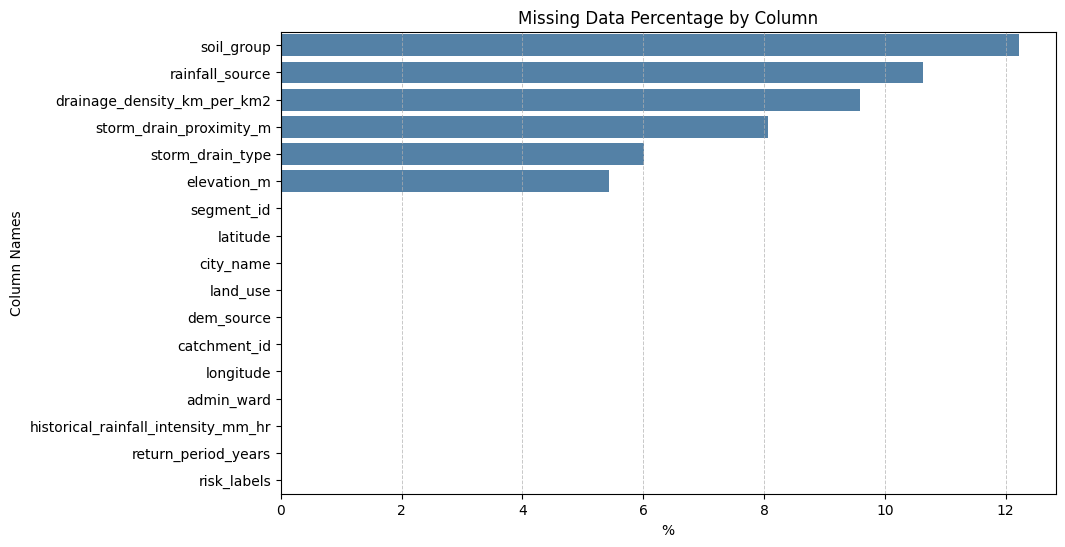

In [3]:
# calculating missing value percentages to assess the reliability of my data, and to see if imputation is needed:
missing_summary = (
    df.isna()
    .sum()
    .reset_index()
    .rename(columns={"index": "column", 0: "missing_count"})
)
missing_summary["missing_%"]=(missing_summary["missing_count"]/len(df)) * 100
missing_summary.sort_values("missing_%", ascending=False, inplace=True)

display(missing_summary)

# Visualising missing values via a barplot:
plt.figure(figsize=(10,6))
sns.barplot(y="column", x="missing_%", data=missing_summary, color="steelblue")
plt.title("Missing Data Percentage by Column")
plt.xlabel("%")
plt.ylabel("Column Names")
plt.grid(True, axis='x', linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

In [4]:
# Logical Validations (range)
# Defining rules:
invalid_elevation = df[df["elevation_m"]<-50] # unrealistic elevation
invalid_rainfall = df[df["historical_rainfall_intensity_mm_hr"]<0]
invalid_drainage = df[df["drainage_density_km_per_km2"]<0]

print("Invalid elevation entries:", len(invalid_elevation))
print("Invalid rainfall entries:", len(invalid_rainfall))
print("Invalid drainage entries:", len(invalid_drainage))

# returns 0 invalid entries

Invalid elevation entries: 0
Invalid rainfall entries: 0
Invalid drainage entries: 0


In [5]:
# Detecting duplicates:
duplicates = df[df.duplicated(subset=["segment_id"])]
print(f"Duplicate segment IDs= {len(duplicates)}")

Duplicate segment IDs= 0


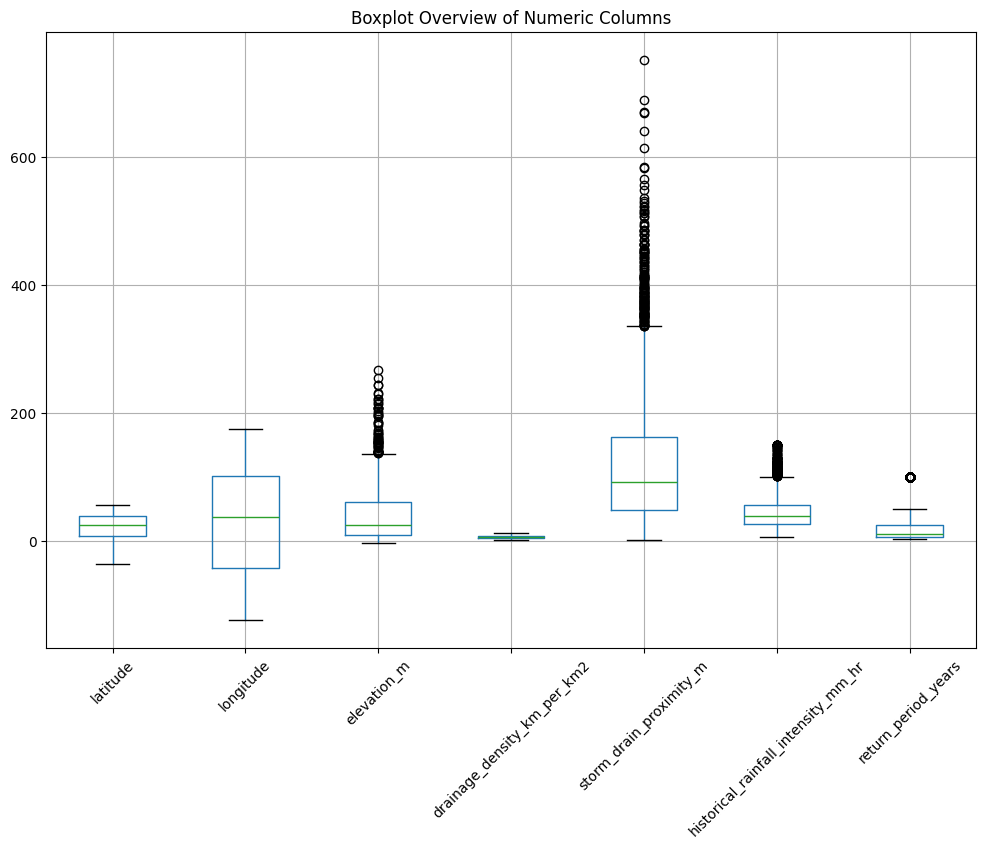

,column,outlier_count
0,latitude,0
1,longitude,0
2,elevation_m,63
3,drainage_density_km_per_km2,0
4,storm_drain_proximity_m,163
5,historical_rainfall_intensity_mm_hr,120
6,return_period_years,174


In [8]:
# Outlier detection (numeric columns)
numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(12,8))
df[numeric_cols].boxplot(rot=45)
plt.title("Boxplot Overview of Numeric Columns")
plt.show()

# Flagging outliers using IQR
outlier_summary = {}
for col in numeric_cols:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR= Q3-Q1
  outliers = df[(df[col]< Q1 - 1.5 * IQR) | (df[col]> Q3 + 1.5*IQR)]
  outlier_summary[col]=len(outliers)
pd.DataFrame(outlier_summary.items(),columns=["column","outlier_count"])


In [12]:
# Computing a data quality score for each column:
quality_report= pd.DataFrame({
    "column":df.columns,
    "missing_%": df.isna().sum() / len(df) * 100,
    "dtype": df.dtypes.astype(str)
})
quality_report["outlier_count"]=quality_report["column"].map(outlier_summary)
quality_report["quality_score"]=(
    100- (quality_report["missing_%"] + (quality_report["outlier_count"] / len(df) * 100))
).clip(lower=0)

display(quality_report.sort_values("quality_score",ascending=False))

,column,missing_%,dtype,outlier_count,quality_score
latitude,latitude,0.000000,float64,0.0,100.000000
longitude,longitude,0.000000,float64,0.0,100.000000
historical_rainfall_intensity_mm_hr,historical_rainfall_intensity_mm_hr,0.000000,float64,120.0,95.950051
return_period_years,return_period_years,0.000000,int64,174.0,94.127573
elevation_m,elevation_m,5.433682,float64,63.0,92.440094
drainage_density_km_per_km2,drainage_density_km_per_km2,9.584880,float64,0.0,90.415120
storm_drain_proximity_m,storm_drain_proximity_m,8.066149,float64,163.0,86.432670
segment_id,segment_id,0.000000,object,NaN,NaN
city_name,city_name,0.000000,object,NaN,NaN
admin_ward,admin_ward,0.000000,object,NaN,NaN


### Geographic-Aware Imputation (Numerical Columns)

---



Since environmental and infrastructure characteristics vary widely between regions,
missing values for numeric variables (`elevation_m`, `drainage_density_km_per_km2`,
`storm_drain_proximity_m`) were imputed using **country-level medians** rather than
a single global median.

This approach preserves regional context, and voids homogenisation of data. For example, a coastal city in Thailand
should inherit values typical of similar Southeast Asian conditions rather than
those from high-altitude cities in Latin America. When a region lacked sufficient
data to compute a median, the global median served as a fallback.

In [15]:
# NUMERICAL COLUMNS:
# Imputing median values for the numerical columns with missing value percentages >0:

# We do this by creating a country column, and then assigning country median for the missing entry in that particular column.

df['country']= df['city_name'].str.split(',').str[-1].str.strip()

# Group wise median imputation:
for col in ['elevation_m','drainage_density_km_per_km2','storm_drain_proximity_m']:
  df[col]=df.groupby('country')[col].transform(
      lambda x: x.fillna(x.median())
  )

### Geographic-Aware Imputation (Categorical Variables)

Categorical features such as `soil_group` and `rainfall_source` were imputed
using **country-level modes** to maintain regional consistency.
For example, if a record from Kenya had a missing `soil_group`, it inherited
the most common soil classification observed in other Kenyan records.  
When a country had no available non-missing values for a variable,
the global mode was used as a fallback.  

This approach ensures categorical imputation reflects local environmental
and measurement patterns rather than imposing globally dominant values
(e.g., preventing Australian rainfall data from influencing Indian observations).

In [19]:
# CATEGORICAL COLUMNS:
# Group wise modal imputation:

# Function to get mode safely:
def safe_mode(series):
  mode_values = series.mode()
  return mode_values[0] if not mode_values.empty else np.nan


for col in ['soil_group','storm_drain_type','rainfall_source']:
  df[col]=df.groupby('country')[col].transform(
      lambda x: x.fillna(x.mode())
  )

# Global value fallback for any remaining missing values:
if df[col].isna().sum()>0:
  df[col].fillna(df[col].mode()[0], inplace=True)

In [23]:
# Saving cleaned, and audited dataset for next stage:
output_path = '/content/drive/MyDrive/Colab Notebooks/cleaned_floor_data.csv'
df.to_csv(output_path, index=False)